In [3]:
import torch
import torch.nn as nn

import numpy as np

In [48]:
class TileEmbeddingVAE(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.debug = debug

        self.imgEncConv1 = nn.Conv2d(3, 32, kernel_size=3, stride=3)
        self.imgEncConv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.imgEncConv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)

        self.imgEncBn1 = nn.BatchNorm2d(32)
        self.imgEncBn2 = nn.BatchNorm2d(32)
        self.imgEncBn3 = nn.BatchNorm2d(16)

        self.imgEncMha = nn.MultiheadAttention(32, 1, batch_first=True)
        self.imgEncScaler = nn.Parameter(torch.zeros(1))

        self.imageEncoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=3),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.Flatten(),
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(13, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
        )

        self.embeddingLayer = nn.Linear(4112, 256)

        self.imageDecoder = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Unflatten(1, (16, 16, 16)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

        self.textDecoder = nn.Sequential(
            nn.Linear(256, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 13),
            nn.Sigmoid(),
        )

    def useAttention(self, x):

        bs, c, h, w = x.shape
        x = x.reshape(bs, c, h * w).transpose(1, 2)

        attOut, attMap = self.imgEncMha(x, x, x)

        if self.debug:
            print(f"attOut shape: {attOut.size()}")
            print(f"attMap shape: {attMap.size()}")

        attOut = attOut.transpose(1, 2).reshape(bs, c, h, w)

        if self.debug:
            print(f"attOut reshaped shape: {attOut.size()}")

        return attOut, attMap

    def encodeImage(self, xImages):

        xImages = self.imgEncConv1(xImages)
        xImages = self.imgEncBn1(xImages)
        
        xImages = self.imgEncScaler * self.useAttention(xImages)[0] + xImages

        xImages = nn.functional.tanh(xImages)

        xImages = self.imgEncConv2(xImages)
        xImages = self.imgEncBn2(xImages)
        xImages = nn.functional.tanh(xImages)

        xImages = self.imgEncConv3(xImages)
        xImages = self.imgEncBn3(xImages)
        xImages = nn.functional.tanh(xImages)

        if self.debug:
            print(f"xImages b4 flatten shape: {xImages.size()}")

        xImages = xImages.flatten(start_dim=1)

        if self.debug:
            print(f"xImages flattened shape: {xImages.size()}")

        return xImages

    def encode(self, xImages, xText):

        if self.debug:
            print(f"xImages shape: {xImages.shape}")
            print(f"xText shape: {xText.shape}")

        encodedImage = self.encodeImage(xImages)

        encodedText = self.textEncoder(xText)

        if self.debug:
            print(f"EncodedImage shape: {encodedImage.size()}")
            print(f"encodedText shape: {encodedText.size()}")

        concatenateEmbeddding = torch.cat((encodedImage, encodedText), 1)

        embedding = self.embeddingLayer(concatenateEmbeddding)

        return embedding

    def decode(self, embedding):
        decodedImage = self.imageDecoder(embedding)
        decodedText = self.textDecoder(embedding)
        return decodedImage, decodedText

    def forward(self, xImages, xText):
        # Encoder
        encodedEmbedding = self.encode(xImages, xText)

        # Decoder
        yPredImage, yPredText = self.decode(encodedEmbedding)
        
        return yPredImage, yPredText

In [51]:
xTrainImages = torch.ones(10, 3, 48, 48)
xTrainText = torch.ones(10, 13)

model = TileEmbeddingVAE(debug=True)

yPredImages, yPredText = model(xTrainImages, xTrainText)

print(f"yPredImages shape: {yPredImages.size()}")
print(f"yPredText shape: {yPredText.size()}")

xImages shape: torch.Size([10, 3, 48, 48])
xText shape: torch.Size([10, 13])
attOut shape: torch.Size([10, 256, 32])
attMap shape: torch.Size([10, 256, 256])
attOut reshaped shape: torch.Size([10, 32, 16, 16])
xImages b4 flatten shape: torch.Size([10, 16, 16, 16])
xImages flattened shape: torch.Size([10, 4096])
EncodedImage shape: torch.Size([10, 4096])
encodedText shape: torch.Size([10, 16])
yPredImages shape: torch.Size([10, 3, 16, 16])
yPredText shape: torch.Size([10, 13])


In [73]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import numpy as np

import Utils.Data.DataLoading as DataLoading

TrainingData = DataLoading.LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)
TrainingData = TrainingData["testData"]

TFIDF Weight Array: tensor([2.1321, 6.2026, 4.0443, 6.4670, 5.1142, 4.9313, 6.8857, 5.3510, 4.8471,
        2.5497, 1.5824, 2.6795, 1.8435])


(5, 256, 256)


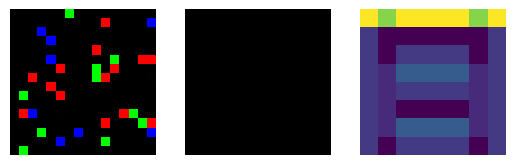

<Figure size 640x480 with 0 Axes>

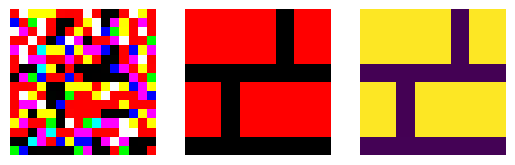

<Figure size 640x480 with 0 Axes>

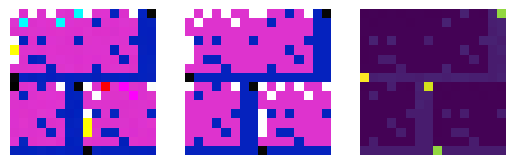

<Figure size 640x480 with 0 Axes>

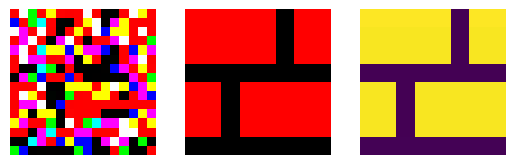

<Figure size 640x480 with 0 Axes>

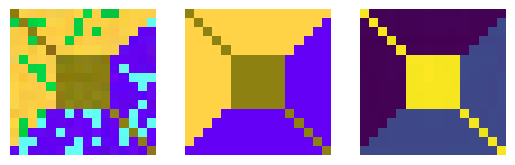

<Figure size 640x480 with 0 Axes>

In [109]:
model = torch.load("Models/firstTryMHA.pt")
model.cpu()
model.eval()

data = TrainingData.iloc[20:25]

xImages = np.array(data["image"].tolist())
yImages = xImages[:, 16:32, 16:32, :]

xImageBatch = torch.tensor(xImages, dtype=torch.float32)
xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))

xTextbatch = torch.tensor(data["encodedAffordances"].tolist(), dtype=torch.float32)

yPredImages, yPredText = model(xImageBatch, xTextbatch)

images = yPredImages.detach().numpy()

x = model.imgEncConv1(xImageBatch)
x = model.imgEncBn1(x)

attMaps = model.useAttention(x)[1].detach().numpy()
print(attMaps.shape)

for i, image in enumerate(images):

    fig, axes = plt.subplots(1, 3)
    
    axes[0].imshow(image.reshape(16, 16, 3).astype(np.uint8))
    axes[0].axis(False)

    axes[1].imshow(yImages[i])
    axes[1].axis(False)

    axes[2].imshow(attMaps[i][128].reshape(16, 16), cmap="viridis")
    axes[2].axis(False)
    
    plt.figure()

In [33]:
a = torch.ones(10, 3, 48, 48)
convLayer = nn.Conv2d(3, 32, kernel_size=3, stride=3)
convOutput = convLayer(a)

batchNorm = nn.BatchNorm2d(32)
batchNormOutput = batchNorm(convOutput)

print(batchNormOutput.shape)

torch.Size([10, 32, 16, 16])


In [39]:
multiHeadLayer = nn.MultiheadAttention(32, 1, batch_first=True)

bs, c, h, w = batchNormOutput.shape
batchNormOutputReshaped = batchNormOutput.reshape(bs, c, h * w).transpose(1, 2)

multiHeadOutput = multiHeadLayer(batchNormOutputReshaped, batchNormOutputReshaped, batchNormOutputReshaped)
print(multiHeadOutput[0].shape)
print(multiHeadOutput[1].shape)

attOut, attMap = multiHeadOutput
attOut = attOut.transpose(1, 2).reshape(bs, c, h, w)

print(attOut.shape)
print(attMap.shape)

torch.Size([10, 256, 32])
torch.Size([10, 256, 256])
torch.Size([10, 32, 16, 16])
torch.Size([10, 256, 256])
